## **This notebook aims to compare some models and store them in a reasonable fashion**

In [1]:
import pandas as pd
import numpy as np
import os
import time
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use GPU 0 in first notebook

In [3]:
project_dir = "/home/jupyter-tfg2425paula/prediction_project_v3"
os.chdir(project_dir)

clean_data_dir = os.path.join(project_dir, "00_data/clean")
horizontal_data_dir = os.path.join(project_dir, "00_data/horizontal_structure")
results_dir = os.path.join(project_dir, "02_results")
plots_dir = os.path.join(project_dir, "03_plots")
pca_data_dir = os.path.join(project_dir, "00_data/pca")

### **GRU Model**

In [4]:
class GRU3DClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(GRU3DClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :]) 
        # return self.sigmoid(out)
        return out

### **LSTM Model**

In [5]:
class StockPriceLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.0):
        super(StockPriceLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                            batch_first=True, dropout=dropout)
    
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        batch_size = x.size(0)  # Get the batch size dynamically

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)  # (num_layers, batch_size, hidden_dim)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)  # (num_layers, batch_size, hidden_dim)
        
        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :]) 
        # out = self.sigmoid(out)
        return out
    

### **Set folders**

Processing

In [6]:
processing_types = ["clean", "pca"]
processing_types= ["clean"]

Folders

In [7]:
# stocks = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'SPX']
stocks = ['AAPL']
# types_securities = ["single_name", "options", "technical"]
types_securities = ["single_name"]

Different files

In [8]:
# years = ["15y", "10y", "5y", "2y"]
years = ["10y"]
# window_sizes = [5, 10, 50, 100]
window_sizes = [5]
# train_sizes = [80, 90, 95]
train_sizes = [95]

Same file

In [9]:
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5]
thresholds = [0.5]
learning_rates = [0.005, 0.008, 0.009, 0.01]
learning_rates = [0.01]
num_epochs_list = [100, 200]
num_epochs_list = [100]
batch_sizes = [16, 32]
batch_sizes = [32]

#### **Model and Hyperparameters**

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

hidden_size = 64  
output_size = 2  
num_layers = 2
dropout = 0.2

criterion = nn.CrossEntropyLoss()

In [11]:
model_types = ["lstm", "gru"]   

#### **Last data modifications**

In [12]:
def reshape_remove_characters(df):

    X = np.array([np.stack(row) for row in df.drop(columns=['Target']).values])
    y = df['Target'].values

    smote = SMOTE(random_state=42)
    n_samples, timesteps, n_features = X.shape
    X_flat = X.reshape((n_samples, timesteps * n_features))
    X_flat = np.where(X_flat == 'ç', 0, X_flat)

    X_resampled = X_flat.reshape((-1, timesteps, n_features))
    
    return X_resampled, y

### **Evaluation function**

In [17]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

def evaluate_model_plot(
    model, 
    X, 
    y, 
    criterion, 
    optimizer, 
    device, 
    train_size, 
    batch_size, 
    num_epochs, 
    lower_threshold,
    plots_dir=None,
    plot_filename=None
):

    # -------------------------------
    # 0) Prepare Tensors & Splits
    # -------------------------------
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)

    total_size = len(X)
    # Determine actual train_size index
    if train_size < 1.0:
        lower_bound = int(train_size * total_size)
    else:
        lower_bound = train_size

    # Training portion
    X_train = X[:lower_bound].to(device)
    y_train = y[:lower_bound].to(device)

    train_dataset = TensorDataset(X_train, y_train)
    trainloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,   # Set True if you prefer shuffling
        drop_last=False
    )

    if lower_bound < total_size:
        X_val = X[lower_bound:].to(device)
        y_val = y[lower_bound:].to(device)
        val_dataset = TensorDataset(X_val, y_val)
        valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    else:
        # If there's no leftover data for "test", handle gracefully
        X_val = None
        y_val = None
        valloader = None

    # ---------------------------------------------
    # 1) SINGLE TRAINING PHASE + Track Loss Curves
    # ---------------------------------------------
    model.to(device)
    model.train()

    epoch_train_losses = []
    epoch_test_losses = []

    for epoch in range(num_epochs):
        # TRAINING PASS
        epoch_loss = 0.0
        for X_batch, y_batch in trainloader:
            optimizer.zero_grad()

            # Forward
            pred_y = model(X_batch)
            loss = criterion(pred_y, y_batch)

            # Backprop & update
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # optional
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(trainloader)
        epoch_train_losses.append(avg_train_loss)

        # VALIDATION PASS (Optional but needed to get test_loss_curve)
        if valloader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for Xb, yb in valloader:
                    pred_yb = model(Xb)
                    loss_b = criterion(pred_yb, yb)
                    val_loss += loss_b.item()
            avg_val_loss = val_loss / len(valloader)
            epoch_test_losses.append(avg_val_loss)

            model.train()  # Switch back to train mode

        else:
            # If no validation set, just store None or 0
            epoch_test_losses.append(None)

        # Print progress every 5 epochs or last epoch
        if (epoch + 1) % 5 == 0 or (epoch == num_epochs - 1):
            if epoch_test_losses[-1] is not None:
                print(f"[Epoch {epoch+1}/{num_epochs}] "
                      f"Train Loss: {avg_train_loss:.4f}, "
                      f"Val Loss: {avg_val_loss:.4f}")
            else:
                print(f"[Epoch {epoch+1}/{num_epochs}] "
                      f"Train Loss: {avg_train_loss:.4f}")

    # % decrease from first to last train loss
    if len(epoch_train_losses) > 1:
        loss_decrease_percentage = ((epoch_train_losses[-1] - epoch_train_losses[0])
                                    / epoch_train_losses[0]) * 100
    else:
        loss_decrease_percentage = 0.0

    final_train_loss = epoch_train_losses[-1]

    # -------------------------------
    # 2) ROLLING PREDICTIONS, NO UPDATE
    # -------------------------------
    model.eval()
    rolling_predictions = []
    rolling_targets = []

    for i in range(lower_bound, total_size):
        X_test = X[i:i+1].to(device)
        y_test = y[i:i+1].to(device)

        with torch.no_grad():
            pred_y = model(X_test)
            probabilities = torch.softmax(pred_y, dim=1).cpu().numpy()
            prob_class_1 = probabilities[:, 1]  # shape: (1,)

            # Threshold-based logic
            pred_classes = np.zeros_like(prob_class_1)
            # Predict -1 if prob < lower_threshold
            pred_classes[prob_class_1 < lower_threshold] = -1
            # Predict +1 if prob > (1 - lower_threshold)
            pred_classes[prob_class_1 > (1 - lower_threshold)] = 1

        rolling_predictions.append(pred_classes[0])
        rolling_targets.append(y_test.item())

    rolling_predictions = np.array(rolling_predictions)
    rolling_targets = np.array(rolling_targets).astype(int)

    # If original labels might be {0,1}, adapt as needed
    rolling_targets[rolling_targets == 0] = -1

    # Filter out zero predictions
    nonzero_mask = (rolling_predictions != 0)
    filtered_preds = rolling_predictions[nonzero_mask]
    filtered_targets = rolling_targets[nonzero_mask]

    if len(filtered_preds) == 0:
        accuracy_nonzero = None
        print("No nonzero predictions, cannot compute thresholded accuracy.")
    else:
        accuracy_nonzero = accuracy_score(filtered_targets, filtered_preds)
        print(f"Accuracy on Nonzero Predictions: {accuracy_nonzero:.4f}")

    # -------------------------------------------------
    # 3) PLOT (if plots_dir is set and there's test data)
    # -------------------------------------------------
    if plots_dir is not None:
        os.makedirs(plots_dir, exist_ok=True)

        # If user didn't provide a filename, create a default
        if plot_filename is None:
            plot_filename = "train_test_loss_curve.png"
        plot_path = os.path.join(plots_dir, plot_filename)

        # Plot the training and validation (test) loss curves
        plt.figure(figsize=(8, 5))
        plt.plot(epoch_train_losses, label="Train Loss")
        # Only plot test loss if it isn't None
        if any(x is not None for x in epoch_test_losses):
            plt.plot(epoch_test_losses, label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Train vs. Test Loss per Epoch")
        plt.legend()
        plt.tight_layout()

        plt.savefig(plot_path)
        plt.show()
        print(f"Loss curves saved to: {plot_path}")

    # ----------------
    # 4) Return results
    # ----------------
    return {
        "rolling_predictions": rolling_predictions,
        "rolling_targets": rolling_targets,
        "filtered_predictions": filtered_preds,
        "filtered_targets": filtered_targets,
        "accuracy_nonzero": accuracy_nonzero,
        "loss_decrease_percentage": loss_decrease_percentage,
        "final_train_loss": final_train_loss,
        "train_loss_curve": epoch_train_losses,
        "test_loss_curve": epoch_test_losses
    }


In [14]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

def evaluate_model_plot_nonval(
    model, 
    X, 
    y, 
    criterion, 
    optimizer, 
    device, 
    train_size, 
    batch_size, 
    num_epochs, 
    lower_threshold,
    plots_dir=None,
    plot_filename=None
):

    # -------------------------------
    # 0) Prepare Tensors & Splits
    # -------------------------------
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)

    total_size = len(X)
    # Determine actual train_size index
    if train_size < 1.0:
        lower_bound = int(train_size * total_size)
    else:
        lower_bound = train_size

    # Training portion
    X_train = X[:lower_bound].to(device)
    y_train = y[:lower_bound].to(device)

    train_dataset = TensorDataset(X_train, y_train)
    trainloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,   # Set True if you prefer shuffling
        drop_last=False
    )

    if lower_bound < total_size:
        X_val = X[lower_bound:].to(device)
        y_val = y[lower_bound:].to(device)
        val_dataset = TensorDataset(X_val, y_val)
        valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    else:
        # If there's no leftover data for "test", handle gracefully
        X_val = None
        y_val = None
        valloader = None

    # ---------------------------------------------
    # 1) SINGLE TRAINING PHASE + Track Loss Curves
    # ---------------------------------------------
    model.to(device)
    model.train()

    epoch_train_losses = []
    epoch_test_losses = []

    for epoch in range(num_epochs):
        # TRAINING PASS
        epoch_loss = 0.0
        for X_batch, y_batch in trainloader:
            optimizer.zero_grad()

            # Forward
            pred_y = model(X_batch)
            loss = criterion(pred_y, y_batch)

            # Backprop & update
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # optional
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(trainloader)
        epoch_train_losses.append(avg_train_loss)

        # Print progress every 5 epochs or last epoch
        if (epoch + 1) % 5 == 0 or (epoch == num_epochs - 1):
            print(f"[Epoch {epoch+1}/{num_epochs}] "
                  f"Train Loss: {avg_train_loss:.4f}")

    # % decrease from first to last train loss
    if len(epoch_train_losses) > 1:
        loss_decrease_percentage = ((epoch_train_losses[-1] - epoch_train_losses[0])
                                    / epoch_train_losses[0]) * 100
    else:
        loss_decrease_percentage = 0.0

    final_train_loss = epoch_train_losses[-1]

    # -------------------------------
    # 2) ROLLING PREDICTIONS, NO UPDATE
    # -------------------------------
    model.eval()
    rolling_predictions = []
    rolling_targets = []

    for i in range(lower_bound, total_size):
        X_test = X[i:i+1].to(device)
        y_test = y[i:i+1].to(device)

        with torch.no_grad():
            pred_y = model(X_test)
            probabilities = torch.softmax(pred_y, dim=1).cpu().numpy()
            prob_class_1 = probabilities[:, 1]  # shape: (1,)

            # Threshold-based logic
            pred_classes = np.zeros_like(prob_class_1)
            # Predict -1 if prob < lower_threshold
            pred_classes[prob_class_1 < lower_threshold] = -1
            # Predict +1 if prob > (1 - lower_threshold)
            pred_classes[prob_class_1 > (1 - lower_threshold)] = 1

        rolling_predictions.append(pred_classes[0])
        rolling_targets.append(y_test.item())

    rolling_predictions = np.array(rolling_predictions)
    rolling_targets = np.array(rolling_targets).astype(int)

    # If original labels might be {0,1}, adapt as needed
    rolling_targets[rolling_targets == 0] = -1

    # Filter out zero predictions
    nonzero_mask = (rolling_predictions != 0)
    filtered_preds = rolling_predictions[nonzero_mask]
    filtered_targets = rolling_targets[nonzero_mask]

    if len(filtered_preds) == 0:
        accuracy_nonzero = None
        print("No nonzero predictions, cannot compute thresholded accuracy.")
    else:
        accuracy_nonzero = accuracy_score(filtered_targets, filtered_preds)
        print(f"Accuracy on Nonzero Predictions: {accuracy_nonzero:.4f}")

    # -------------------------------------------------
    # 3) PLOT (if plots_dir is set and there's test data)
    # -------------------------------------------------
    if plots_dir is not None:
        os.makedirs(plots_dir, exist_ok=True)

        # If user didn't provide a filename, create a default
        if plot_filename is None:
            plot_filename = "train_test_loss_curve.png"
        plot_path = os.path.join(plots_dir, plot_filename)

        # Plot the training and validation (test) loss curves
        plt.figure(figsize=(8, 5))
        plt.plot(epoch_train_losses, label="Train Loss")
        # Only plot test loss if it isn't None
        if any(x is not None for x in epoch_test_losses):
            plt.plot(epoch_test_losses, label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Train vs. Test Loss per Epoch")
        plt.legend()
        plt.tight_layout()

        plt.savefig(plot_path)
        plt.show()
        print(f"Loss curves saved to: {plot_path}")

    # ----------------
    # 4) Return results
    # ----------------
    return {
        "rolling_predictions": rolling_predictions,
        "rolling_targets": rolling_targets,
        "filtered_predictions": filtered_preds,
        "filtered_targets": filtered_targets,
        "accuracy_nonzero": accuracy_nonzero,
        "loss_decrease_percentage": loss_decrease_percentage,
        "final_train_loss": final_train_loss,
        "train_loss_curve": epoch_train_losses,
        "test_loss_curve": epoch_test_losses
    }


### **Execute evaluation funcion**


----- WINDOW_SIZE: 5, SECURITY_TYPE: single_name, MODEL_TYPE: lstm -----
Training SPX | Iteration: 1 | Model: lstm | Window_size: 5 | Security type: single_name
[Epoch 5/100] Train Loss: 0.6915, Val Loss: 0.6988
[Epoch 10/100] Train Loss: 0.6880, Val Loss: 0.7012
[Epoch 15/100] Train Loss: 0.6865, Val Loss: 0.7040
[Epoch 20/100] Train Loss: 0.6848, Val Loss: 0.7049
[Epoch 25/100] Train Loss: 0.6825, Val Loss: 0.7033
[Epoch 30/100] Train Loss: 0.6774, Val Loss: 0.6984
[Epoch 35/100] Train Loss: 0.6707, Val Loss: 0.6940
[Epoch 40/100] Train Loss: 0.6646, Val Loss: 0.6962
[Epoch 45/100] Train Loss: 0.6542, Val Loss: 0.7035
[Epoch 50/100] Train Loss: 0.6461, Val Loss: 0.7190
[Epoch 55/100] Train Loss: 0.6383, Val Loss: 0.7393
[Epoch 60/100] Train Loss: 0.6291, Val Loss: 0.7501
[Epoch 65/100] Train Loss: 0.6216, Val Loss: 0.7575
[Epoch 70/100] Train Loss: 0.6167, Val Loss: 0.7673
[Epoch 75/100] Train Loss: 0.6124, Val Loss: 0.7791
[Epoch 80/100] Train Loss: 0.6058, Val Loss: 0.7935
[Epoch 

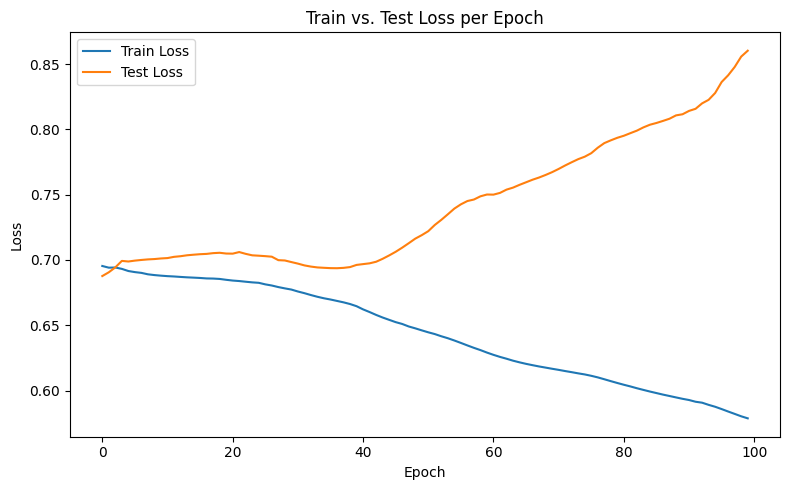

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/overfitting/SPX_val_lstm_5_single_name.png
Training SPX | Iteration: 1 | Model: gru | Window_size: 5 | Security type: single_name
[Epoch 5/100] Train Loss: 0.6932, Val Loss: 0.6939
[Epoch 10/100] Train Loss: 0.6932, Val Loss: 0.6931
[Epoch 15/100] Train Loss: 0.6932, Val Loss: 0.6941
[Epoch 20/100] Train Loss: 0.6941, Val Loss: 0.6937
[Epoch 25/100] Train Loss: 0.6926, Val Loss: 0.7096
[Epoch 30/100] Train Loss: 0.6923, Val Loss: 0.7022
[Epoch 35/100] Train Loss: 0.6873, Val Loss: 0.7113
[Epoch 40/100] Train Loss: 0.6846, Val Loss: 0.7027
[Epoch 45/100] Train Loss: 0.6773, Val Loss: 0.7405
[Epoch 50/100] Train Loss: 0.6729, Val Loss: 0.7274
[Epoch 55/100] Train Loss: 0.6627, Val Loss: 0.7613
[Epoch 60/100] Train Loss: 0.6601, Val Loss: 0.7787
[Epoch 65/100] Train Loss: 0.6492, Val Loss: 0.7796
[Epoch 70/100] Train Loss: 0.6396, Val Loss: 0.8239
[Epoch 75/100] Train Loss: 0.6424, Val Loss: 0.8282
[Epoch 80/1

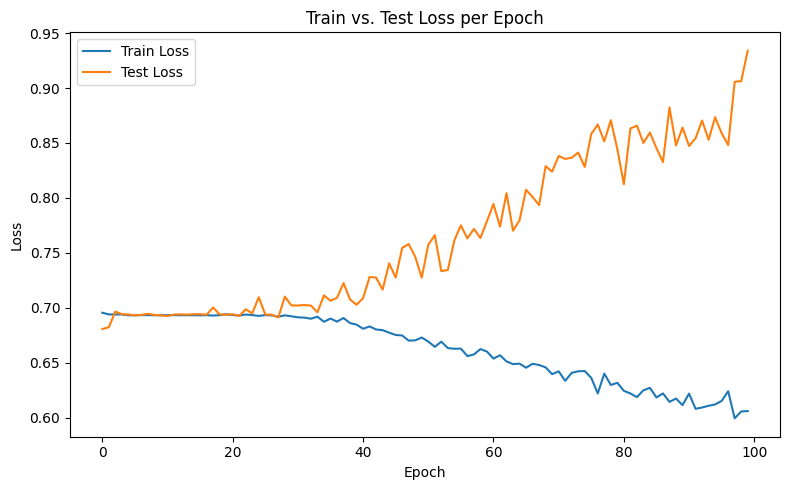

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/overfitting/SPX_val_gru_5_single_name.png

----- WINDOW_SIZE: 10, SECURITY_TYPE: single_name, MODEL_TYPE: gru -----
Training SPX | Iteration: 1 | Model: lstm | Window_size: 10 | Security type: single_name
[Epoch 5/100] Train Loss: 0.6809, Val Loss: 0.6969
[Epoch 10/100] Train Loss: 0.6437, Val Loss: 0.7238
[Epoch 15/100] Train Loss: 0.5953, Val Loss: 0.8092
[Epoch 20/100] Train Loss: 0.5369, Val Loss: 0.8987
[Epoch 25/100] Train Loss: 0.4741, Val Loss: 0.9544
[Epoch 30/100] Train Loss: 0.4165, Val Loss: 1.0457
[Epoch 35/100] Train Loss: 0.3699, Val Loss: 1.1494
[Epoch 40/100] Train Loss: 0.3226, Val Loss: 1.2814
[Epoch 45/100] Train Loss: 0.2796, Val Loss: 1.4083
[Epoch 50/100] Train Loss: 0.2305, Val Loss: 1.6306
[Epoch 55/100] Train Loss: 0.1950, Val Loss: 1.8558
[Epoch 60/100] Train Loss: 0.2124, Val Loss: 2.2202
[Epoch 65/100] Train Loss: 0.1454, Val Loss: 2.3637
[Epoch 70/100] Train Loss: 0.1251, Val L

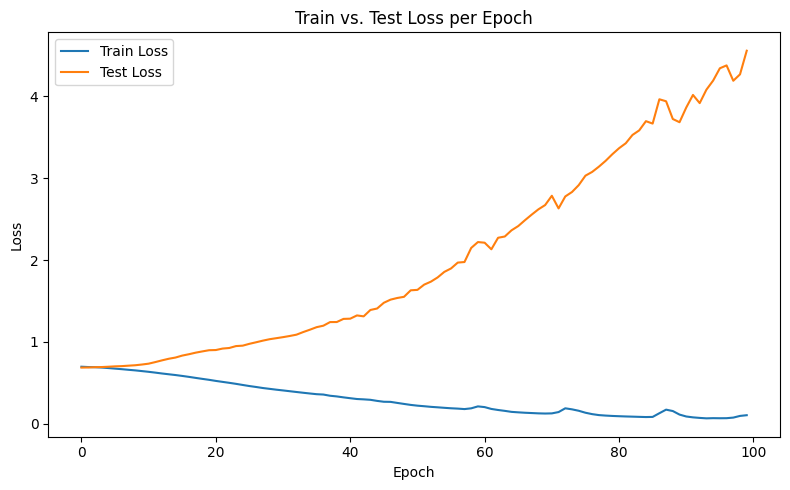

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/overfitting/SPX_val_lstm_10_single_name.png
Training SPX | Iteration: 1 | Model: gru | Window_size: 10 | Security type: single_name
[Epoch 5/100] Train Loss: 0.6900, Val Loss: 0.6878
[Epoch 10/100] Train Loss: 0.6796, Val Loss: 0.6968
[Epoch 15/100] Train Loss: 0.6518, Val Loss: 0.7180
[Epoch 20/100] Train Loss: 0.6171, Val Loss: 0.7241
[Epoch 25/100] Train Loss: 0.5666, Val Loss: 0.8101
[Epoch 30/100] Train Loss: 0.5321, Val Loss: 0.8397
[Epoch 35/100] Train Loss: 0.5011, Val Loss: 0.8104
[Epoch 40/100] Train Loss: 0.4741, Val Loss: 0.8947
[Epoch 45/100] Train Loss: 0.4535, Val Loss: 1.0414
[Epoch 50/100] Train Loss: 0.4247, Val Loss: 0.9751
[Epoch 55/100] Train Loss: 0.4247, Val Loss: 0.9735
[Epoch 60/100] Train Loss: 0.3981, Val Loss: 1.1358
[Epoch 65/100] Train Loss: 0.4121, Val Loss: 1.0789
[Epoch 70/100] Train Loss: 0.3908, Val Loss: 1.2050
[Epoch 75/100] Train Loss: 0.3636, Val Loss: 1.2700
[Epoch 80

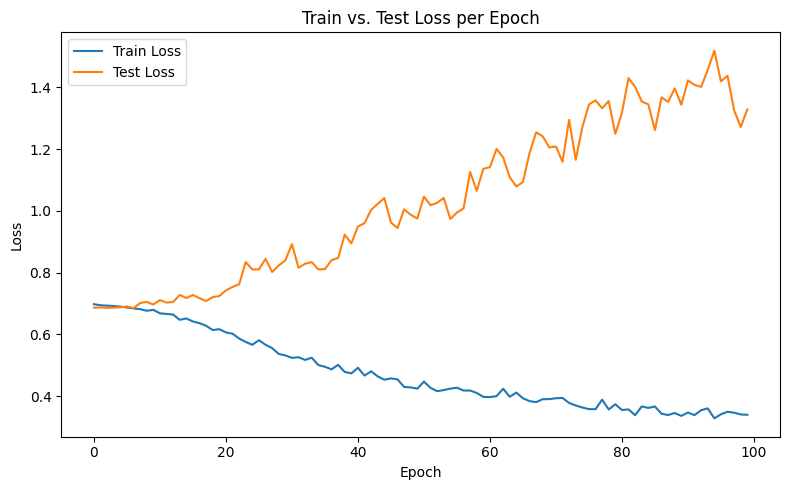

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/overfitting/SPX_val_gru_10_single_name.png

----- WINDOW_SIZE: 50, SECURITY_TYPE: single_name, MODEL_TYPE: gru -----
Training SPX | Iteration: 1 | Model: lstm | Window_size: 50 | Security type: single_name
[Epoch 5/100] Train Loss: 0.4402, Val Loss: 1.0084
[Epoch 10/100] Train Loss: 0.0240, Val Loss: 1.8897
[Epoch 15/100] Train Loss: 0.0038, Val Loss: 2.2726
[Epoch 20/100] Train Loss: 0.0015, Val Loss: 2.4883
[Epoch 25/100] Train Loss: 0.0008, Val Loss: 2.6502
[Epoch 30/100] Train Loss: 0.0004, Val Loss: 2.7866
[Epoch 35/100] Train Loss: 0.0003, Val Loss: 2.9083
[Epoch 40/100] Train Loss: 0.0002, Val Loss: 3.0206
[Epoch 45/100] Train Loss: 0.0001, Val Loss: 3.1260
[Epoch 50/100] Train Loss: 0.0001, Val Loss: 3.2261
[Epoch 55/100] Train Loss: 0.0000, Val Loss: 3.3221
[Epoch 60/100] Train Loss: 0.0000, Val Loss: 3.4149
[Epoch 65/100] Train Loss: 0.0000, Val Loss: 3.5050
[Epoch 70/100] Train Loss: 0.0000, Val 

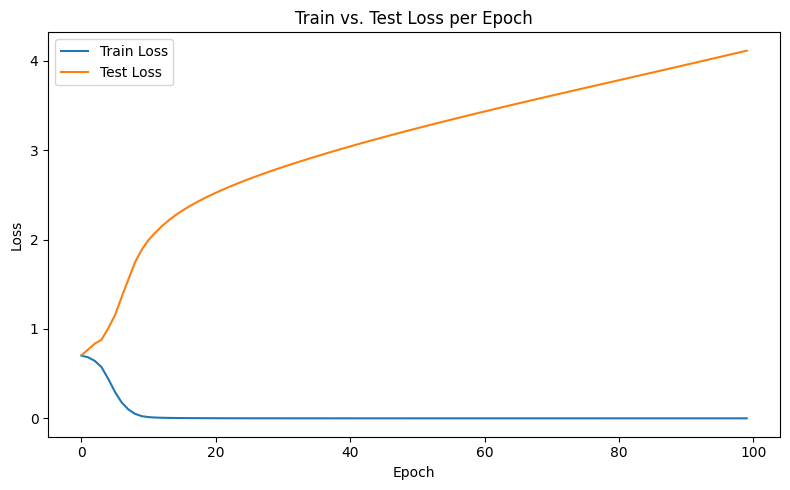

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/overfitting/SPX_val_lstm_50_single_name.png
Training SPX | Iteration: 1 | Model: gru | Window_size: 50 | Security type: single_name
[Epoch 5/100] Train Loss: 0.6740, Val Loss: 0.7658
[Epoch 10/100] Train Loss: 0.5051, Val Loss: 0.8982
[Epoch 15/100] Train Loss: 0.3046, Val Loss: 1.3104
[Epoch 20/100] Train Loss: 0.2230, Val Loss: 1.6694
[Epoch 25/100] Train Loss: 0.1785, Val Loss: 1.9980
[Epoch 30/100] Train Loss: 0.1861, Val Loss: 2.2306
[Epoch 35/100] Train Loss: 0.1123, Val Loss: 2.1332
[Epoch 40/100] Train Loss: 0.1191, Val Loss: 1.7545
[Epoch 45/100] Train Loss: 0.0923, Val Loss: 1.9879
[Epoch 50/100] Train Loss: 0.1134, Val Loss: 1.9696
[Epoch 55/100] Train Loss: 0.0886, Val Loss: 2.0724
[Epoch 60/100] Train Loss: 0.0779, Val Loss: 2.2588
[Epoch 65/100] Train Loss: 0.0836, Val Loss: 2.3969
[Epoch 70/100] Train Loss: 0.0721, Val Loss: 2.6074
[Epoch 75/100] Train Loss: 0.0620, Val Loss: 2.4246
[Epoch 80

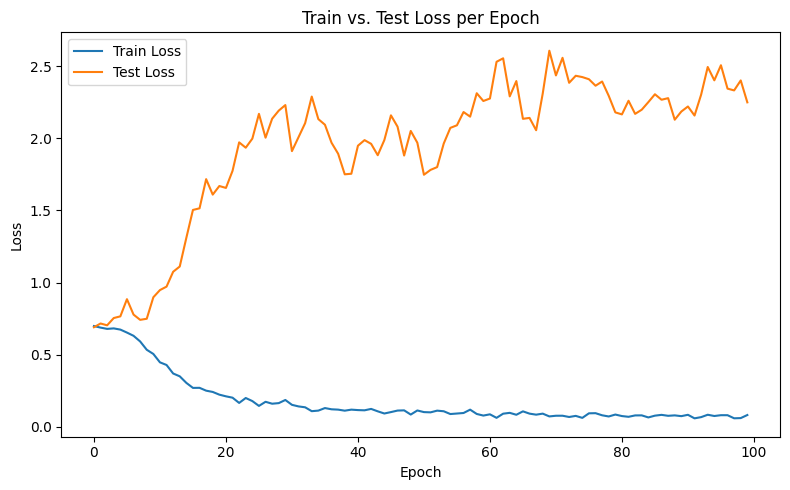

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/overfitting/SPX_val_gru_50_single_name.png

----- WINDOW_SIZE: 100, SECURITY_TYPE: single_name, MODEL_TYPE: gru -----
Training SPX | Iteration: 1 | Model: lstm | Window_size: 100 | Security type: single_name
[Epoch 5/100] Train Loss: 0.1314, Val Loss: 0.9518
[Epoch 10/100] Train Loss: 0.0032, Val Loss: 1.2125
[Epoch 15/100] Train Loss: 0.0011, Val Loss: 1.3467
[Epoch 20/100] Train Loss: 0.0005, Val Loss: 1.4445
[Epoch 25/100] Train Loss: 0.0003, Val Loss: 1.5260
[Epoch 30/100] Train Loss: 0.0002, Val Loss: 1.5987
[Epoch 35/100] Train Loss: 0.0001, Val Loss: 1.6659
[Epoch 40/100] Train Loss: 0.0001, Val Loss: 1.7292
[Epoch 45/100] Train Loss: 0.0000, Val Loss: 1.7893
[Epoch 50/100] Train Loss: 0.0000, Val Loss: 1.8475
[Epoch 55/100] Train Loss: 0.0000, Val Loss: 1.9048
[Epoch 60/100] Train Loss: 0.0000, Val Loss: 1.9617
[Epoch 65/100] Train Loss: 0.0000, Val Loss: 2.0185
[Epoch 70/100] Train Loss: 0.0000, Va

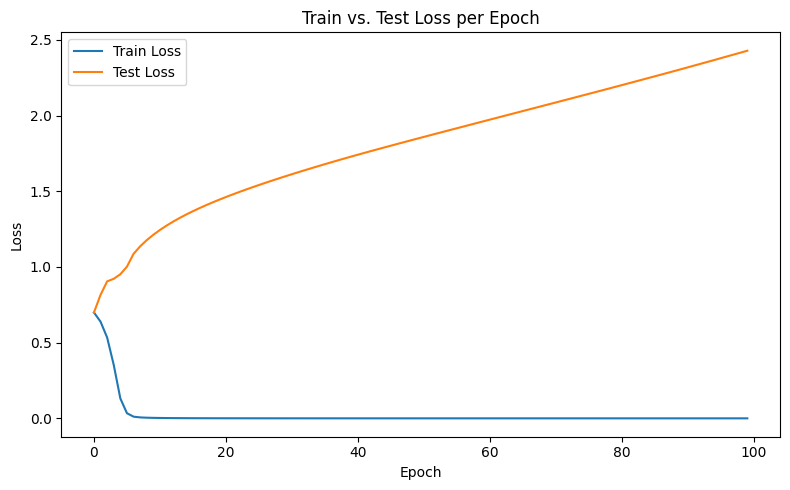

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/overfitting/SPX_val_lstm_100_single_name.png
Training SPX | Iteration: 1 | Model: gru | Window_size: 100 | Security type: single_name
[Epoch 5/100] Train Loss: 0.5466, Val Loss: 0.9359
[Epoch 10/100] Train Loss: 0.3270, Val Loss: 1.1394
[Epoch 15/100] Train Loss: 0.1412, Val Loss: 1.4456
[Epoch 20/100] Train Loss: 0.1012, Val Loss: 1.8164
[Epoch 25/100] Train Loss: 0.0747, Val Loss: 1.9501
[Epoch 30/100] Train Loss: 0.0871, Val Loss: 1.8882
[Epoch 35/100] Train Loss: 0.0726, Val Loss: 2.1574
[Epoch 40/100] Train Loss: 0.0639, Val Loss: 2.1119
[Epoch 45/100] Train Loss: 0.0651, Val Loss: 2.0366
[Epoch 50/100] Train Loss: 0.0382, Val Loss: 2.3093
[Epoch 55/100] Train Loss: 0.0656, Val Loss: 1.9423
[Epoch 60/100] Train Loss: 0.0481, Val Loss: 1.8816
[Epoch 65/100] Train Loss: 0.0506, Val Loss: 1.7214
[Epoch 70/100] Train Loss: 0.0499, Val Loss: 2.1041
[Epoch 75/100] Train Loss: 0.0576, Val Loss: 2.2414
[Epoch 

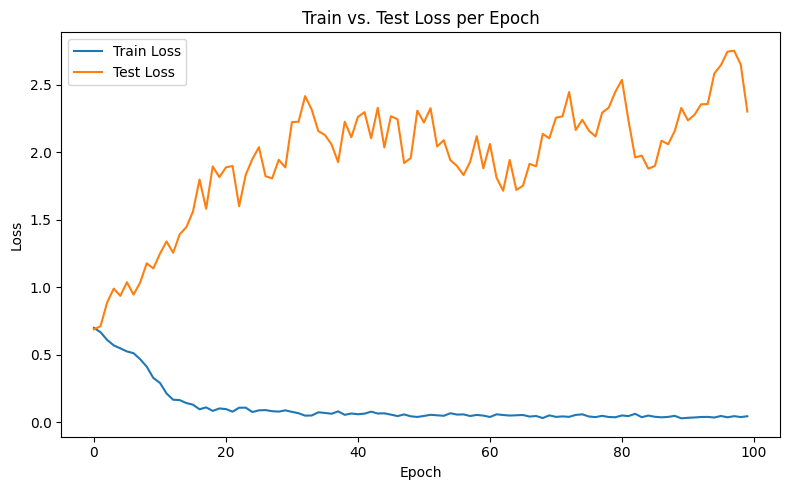

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/overfitting/SPX_val_gru_100_single_name.png

----- WINDOW_SIZE: 5, SECURITY_TYPE: options, MODEL_TYPE: gru -----
Training SPX | Iteration: 1 | Model: lstm | Window_size: 5 | Security type: options
[Epoch 5/100] Train Loss: 0.6931, Val Loss: 0.6881
[Epoch 10/100] Train Loss: 0.6797, Val Loss: 0.6741
[Epoch 15/100] Train Loss: 0.6123, Val Loss: 0.7758
[Epoch 20/100] Train Loss: 0.5229, Val Loss: 0.8346
[Epoch 25/100] Train Loss: 0.3689, Val Loss: 1.1501
[Epoch 30/100] Train Loss: 0.2539, Val Loss: 1.3824
[Epoch 35/100] Train Loss: 0.1634, Val Loss: 1.8984
[Epoch 40/100] Train Loss: 0.1313, Val Loss: 1.9510
[Epoch 45/100] Train Loss: 0.1077, Val Loss: 2.1548
[Epoch 50/100] Train Loss: 0.0897, Val Loss: 2.2751
[Epoch 55/100] Train Loss: 0.0710, Val Loss: 2.8884
[Epoch 60/100] Train Loss: 0.0616, Val Loss: 3.0722
[Epoch 65/100] Train Loss: 0.0691, Val Loss: 2.8949
[Epoch 70/100] Train Loss: 0.0583, Val Loss: 3.1

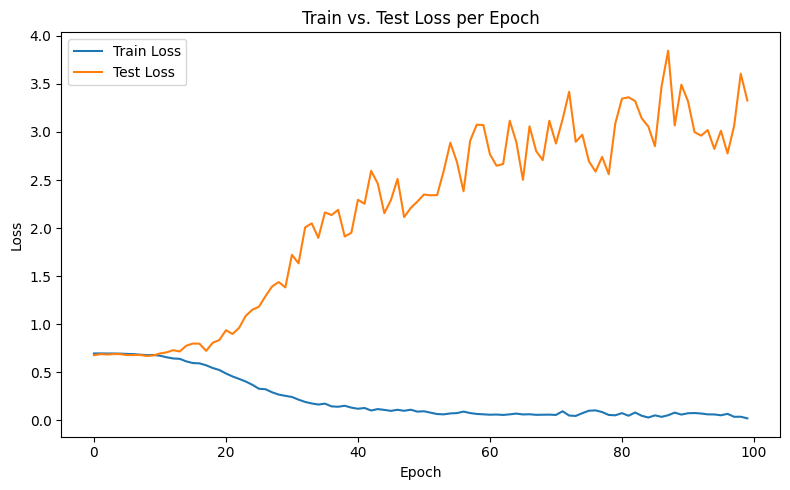

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/overfitting/SPX_val_lstm_5_options.png
Training SPX | Iteration: 1 | Model: gru | Window_size: 5 | Security type: options
[Epoch 5/100] Train Loss: 0.6928, Val Loss: 0.6644
[Epoch 10/100] Train Loss: 0.6939, Val Loss: 0.6941
[Epoch 15/100] Train Loss: 0.6930, Val Loss: 0.6900
[Epoch 20/100] Train Loss: 0.6943, Val Loss: 0.6991
[Epoch 25/100] Train Loss: 0.6965, Val Loss: 0.6761
[Epoch 30/100] Train Loss: 0.6913, Val Loss: 0.6735
[Epoch 35/100] Train Loss: 0.6882, Val Loss: 0.6650
[Epoch 40/100] Train Loss: 0.6809, Val Loss: 0.6777
[Epoch 45/100] Train Loss: 0.6825, Val Loss: 0.6985
[Epoch 50/100] Train Loss: 0.6813, Val Loss: 0.6740
[Epoch 55/100] Train Loss: 0.6779, Val Loss: 0.6753
[Epoch 60/100] Train Loss: 0.6749, Val Loss: 0.6845
[Epoch 65/100] Train Loss: 0.6719, Val Loss: 0.6966
[Epoch 70/100] Train Loss: 0.6827, Val Loss: 0.6749
[Epoch 75/100] Train Loss: 0.6771, Val Loss: 0.6753
[Epoch 80/100] Trai

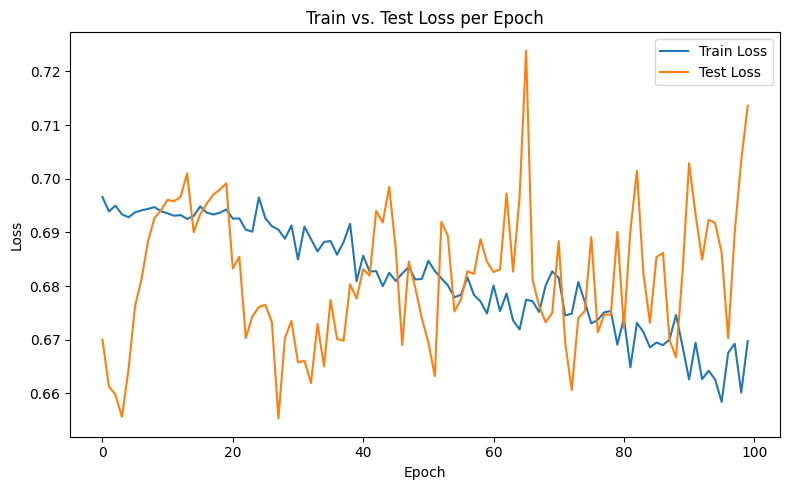

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/overfitting/SPX_val_gru_5_options.png

----- WINDOW_SIZE: 10, SECURITY_TYPE: options, MODEL_TYPE: gru -----
Training SPX | Iteration: 1 | Model: lstm | Window_size: 10 | Security type: options
[Epoch 5/100] Train Loss: 0.6719, Val Loss: 0.6994
[Epoch 10/100] Train Loss: 0.5637, Val Loss: 0.8318
[Epoch 15/100] Train Loss: 0.3269, Val Loss: 1.1456
[Epoch 20/100] Train Loss: 0.1764, Val Loss: 1.9435
[Epoch 25/100] Train Loss: 0.1028, Val Loss: 2.3727
[Epoch 30/100] Train Loss: 0.0877, Val Loss: 2.4415
[Epoch 35/100] Train Loss: 0.0310, Val Loss: 2.9962
[Epoch 40/100] Train Loss: 0.0688, Val Loss: 3.5922
[Epoch 45/100] Train Loss: 0.0580, Val Loss: 3.8118
[Epoch 50/100] Train Loss: 0.0188, Val Loss: 3.9085
[Epoch 55/100] Train Loss: 0.0412, Val Loss: 4.1873
[Epoch 60/100] Train Loss: 0.0440, Val Loss: 4.0739
[Epoch 65/100] Train Loss: 0.0221, Val Loss: 4.3564
[Epoch 70/100] Train Loss: 0.0403, Val Loss: 4.6798


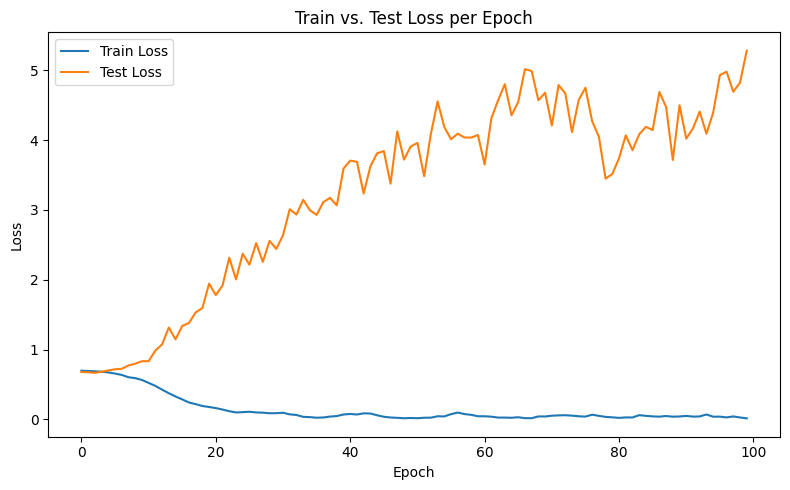

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/overfitting/SPX_val_lstm_10_options.png
Training SPX | Iteration: 1 | Model: gru | Window_size: 10 | Security type: options
[Epoch 5/100] Train Loss: 0.7006, Val Loss: 0.6739
[Epoch 10/100] Train Loss: 0.6934, Val Loss: 0.6683
[Epoch 15/100] Train Loss: 0.6894, Val Loss: 0.6696
[Epoch 20/100] Train Loss: 0.6859, Val Loss: 0.6614
[Epoch 25/100] Train Loss: 0.6780, Val Loss: 0.6722
[Epoch 30/100] Train Loss: 0.6790, Val Loss: 0.6807
[Epoch 35/100] Train Loss: 0.6721, Val Loss: 0.6781
[Epoch 40/100] Train Loss: 0.6676, Val Loss: 0.6776
[Epoch 45/100] Train Loss: 0.6664, Val Loss: 0.6815
[Epoch 50/100] Train Loss: 0.6723, Val Loss: 0.6966
[Epoch 55/100] Train Loss: 0.6739, Val Loss: 0.7246
[Epoch 60/100] Train Loss: 0.6678, Val Loss: 0.7149
[Epoch 65/100] Train Loss: 0.6560, Val Loss: 0.6736
[Epoch 70/100] Train Loss: 0.6566, Val Loss: 0.6799
[Epoch 75/100] Train Loss: 0.6561, Val Loss: 0.7031
[Epoch 80/100] Tr

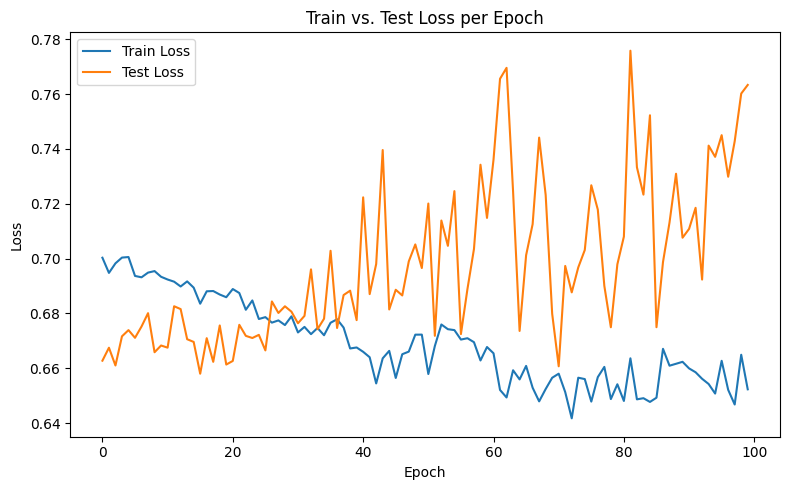

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/overfitting/SPX_val_gru_10_options.png

----- WINDOW_SIZE: 50, SECURITY_TYPE: options, MODEL_TYPE: gru -----
Training SPX | Iteration: 1 | Model: lstm | Window_size: 50 | Security type: options
[Epoch 5/100] Train Loss: 0.3882, Val Loss: 1.1691
[Epoch 10/100] Train Loss: 0.0472, Val Loss: 1.3154
[Epoch 15/100] Train Loss: 0.0015, Val Loss: 1.5833
[Epoch 20/100] Train Loss: 0.0006, Val Loss: 1.6699
[Epoch 25/100] Train Loss: 0.0003, Val Loss: 1.7433
[Epoch 30/100] Train Loss: 0.0002, Val Loss: 1.8077
[Epoch 35/100] Train Loss: 0.0001, Val Loss: 1.8661
[Epoch 40/100] Train Loss: 0.0001, Val Loss: 1.9206
[Epoch 45/100] Train Loss: 0.0000, Val Loss: 1.9723
[Epoch 50/100] Train Loss: 0.0000, Val Loss: 2.0222
[Epoch 55/100] Train Loss: 0.0000, Val Loss: 2.0710
[Epoch 60/100] Train Loss: 0.0000, Val Loss: 2.1192
[Epoch 65/100] Train Loss: 0.0000, Val Loss: 2.1674
[Epoch 70/100] Train Loss: 0.0000, Val Loss: 2.2162

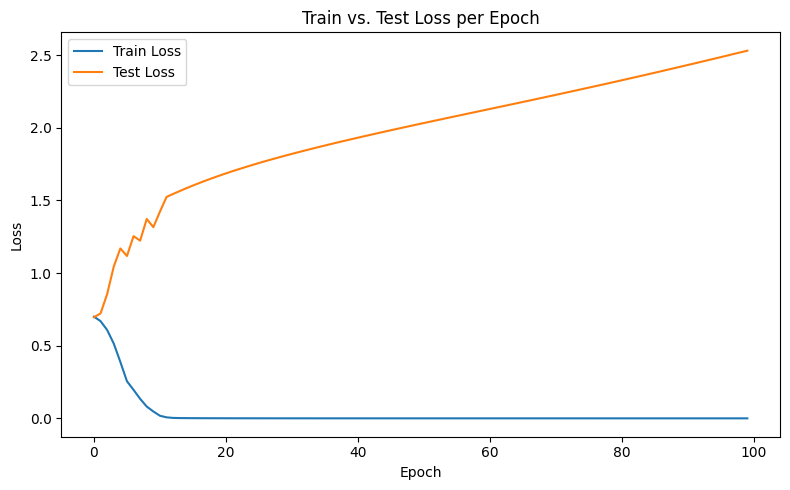

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/overfitting/SPX_val_lstm_50_options.png
Training SPX | Iteration: 1 | Model: gru | Window_size: 50 | Security type: options
[Epoch 5/100] Train Loss: 0.7122, Val Loss: 0.7782
[Epoch 10/100] Train Loss: 0.6888, Val Loss: 0.7434
[Epoch 15/100] Train Loss: 0.6573, Val Loss: 0.7836
[Epoch 20/100] Train Loss: 0.6042, Val Loss: 0.8806
[Epoch 25/100] Train Loss: 0.5827, Val Loss: 1.0454
[Epoch 30/100] Train Loss: 0.5641, Val Loss: 1.0637
[Epoch 35/100] Train Loss: 0.5154, Val Loss: 1.0525
[Epoch 40/100] Train Loss: 0.4886, Val Loss: 1.0034
[Epoch 45/100] Train Loss: 0.4480, Val Loss: 1.0770
[Epoch 50/100] Train Loss: 0.4366, Val Loss: 1.1238
[Epoch 55/100] Train Loss: 0.3947, Val Loss: 1.3416
[Epoch 60/100] Train Loss: 0.4144, Val Loss: 1.3553
[Epoch 65/100] Train Loss: 0.4034, Val Loss: 1.0628
[Epoch 70/100] Train Loss: 0.3753, Val Loss: 1.4571
[Epoch 75/100] Train Loss: 0.4079, Val Loss: 1.2645
[Epoch 80/100] Tr

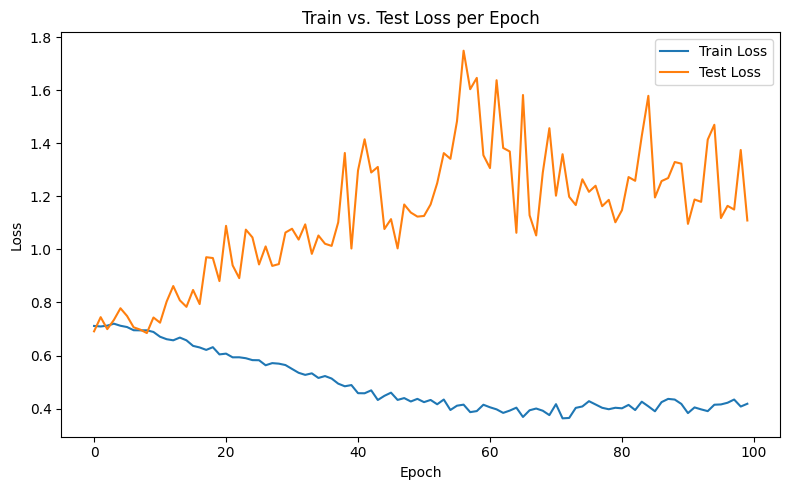

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/overfitting/SPX_val_gru_50_options.png

----- WINDOW_SIZE: 100, SECURITY_TYPE: options, MODEL_TYPE: gru -----
Training SPX | Iteration: 1 | Model: lstm | Window_size: 100 | Security type: options
[Epoch 5/100] Train Loss: 0.2315, Val Loss: 1.2213
[Epoch 10/100] Train Loss: 0.0025, Val Loss: 1.6989
[Epoch 15/100] Train Loss: 0.0008, Val Loss: 1.8378
[Epoch 20/100] Train Loss: 0.0004, Val Loss: 1.9419
[Epoch 25/100] Train Loss: 0.0002, Val Loss: 2.0307
[Epoch 30/100] Train Loss: 0.0001, Val Loss: 2.1111
[Epoch 35/100] Train Loss: 0.0001, Val Loss: 2.1860
[Epoch 40/100] Train Loss: 0.0000, Val Loss: 2.2569
[Epoch 45/100] Train Loss: 0.0000, Val Loss: 2.3244
[Epoch 50/100] Train Loss: 0.0000, Val Loss: 2.3888
[Epoch 55/100] Train Loss: 0.0000, Val Loss: 2.4504
[Epoch 60/100] Train Loss: 0.0000, Val Loss: 2.5093
[Epoch 65/100] Train Loss: 0.0000, Val Loss: 2.5659
[Epoch 70/100] Train Loss: 0.0000, Val Loss: 2.62

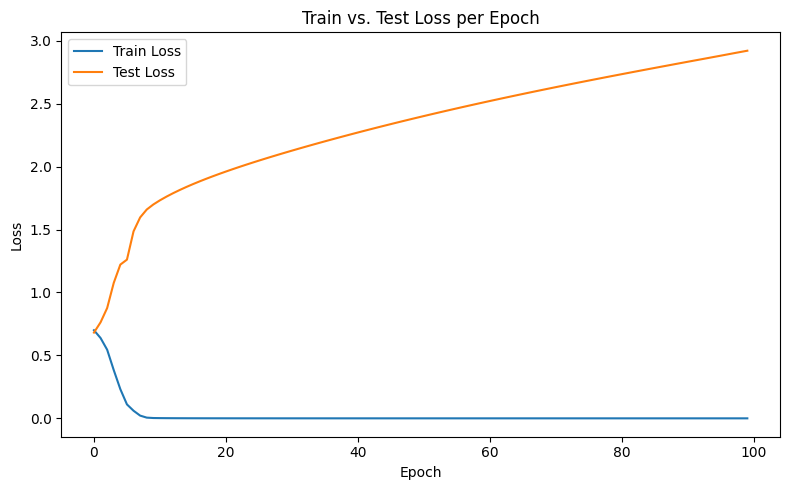

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/overfitting/SPX_val_lstm_100_options.png
Training SPX | Iteration: 1 | Model: gru | Window_size: 100 | Security type: options
[Epoch 5/100] Train Loss: 0.6747, Val Loss: 0.6977
[Epoch 10/100] Train Loss: 0.5986, Val Loss: 0.8359
[Epoch 15/100] Train Loss: 0.4873, Val Loss: 1.1779
[Epoch 20/100] Train Loss: 0.4151, Val Loss: 1.2878
[Epoch 25/100] Train Loss: 0.3655, Val Loss: 1.4925
[Epoch 30/100] Train Loss: 0.3016, Val Loss: 1.6857
[Epoch 35/100] Train Loss: 0.3069, Val Loss: 1.9506
[Epoch 40/100] Train Loss: 0.2933, Val Loss: 1.4738
[Epoch 45/100] Train Loss: 0.2697, Val Loss: 1.7549
[Epoch 50/100] Train Loss: 0.2872, Val Loss: 1.7900
[Epoch 55/100] Train Loss: 0.2782, Val Loss: 1.8166
[Epoch 60/100] Train Loss: 0.2419, Val Loss: 1.9647
[Epoch 65/100] Train Loss: 0.2301, Val Loss: 1.9240
[Epoch 70/100] Train Loss: 0.2126, Val Loss: 2.1705
[Epoch 75/100] Train Loss: 0.2077, Val Loss: 2.2262
[Epoch 80/100] 

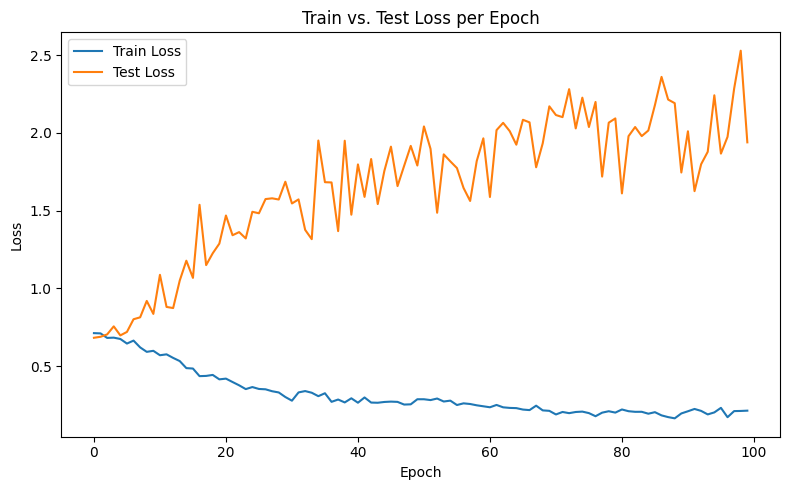

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/overfitting/SPX_val_gru_100_options.png

----- WINDOW_SIZE: 5, SECURITY_TYPE: technical, MODEL_TYPE: gru -----
Training SPX | Iteration: 1 | Model: lstm | Window_size: 5 | Security type: technical
[Epoch 5/100] Train Loss: 0.6915, Val Loss: 0.6771
[Epoch 10/100] Train Loss: 0.6776, Val Loss: 0.6817
[Epoch 15/100] Train Loss: 0.6282, Val Loss: 0.7096
[Epoch 20/100] Train Loss: 0.5531, Val Loss: 0.7657
[Epoch 25/100] Train Loss: 0.4678, Val Loss: 0.8006
[Epoch 30/100] Train Loss: 0.3955, Val Loss: 0.9634
[Epoch 35/100] Train Loss: 0.3106, Val Loss: 1.1246
[Epoch 40/100] Train Loss: 0.2229, Val Loss: 1.3506
[Epoch 45/100] Train Loss: 0.2030, Val Loss: 1.4126
[Epoch 50/100] Train Loss: 0.1503, Val Loss: 1.8405
[Epoch 55/100] Train Loss: 0.1535, Val Loss: 1.7141
[Epoch 60/100] Train Loss: 0.1692, Val Loss: 2.1569
[Epoch 65/100] Train Loss: 0.1191, Val Loss: 2.3093
[Epoch 70/100] Train Loss: 0.1320, Val Loss: 2.4

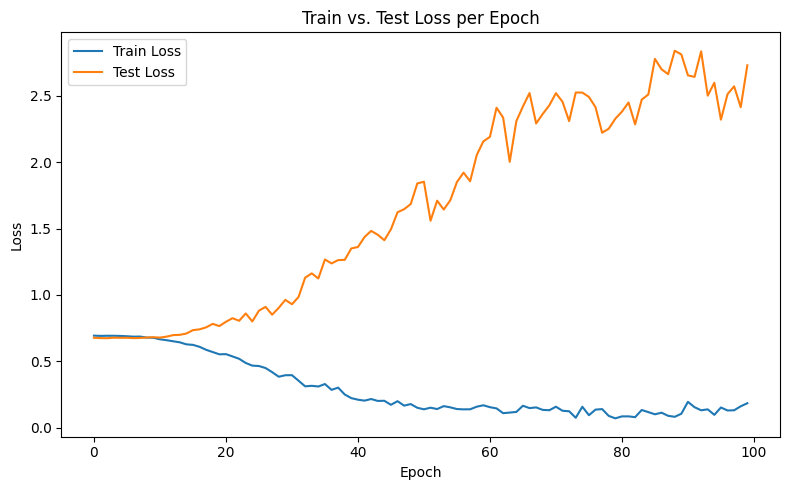

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/overfitting/SPX_val_lstm_5_technical.png
Training SPX | Iteration: 1 | Model: gru | Window_size: 5 | Security type: technical
[Epoch 5/100] Train Loss: 0.6963, Val Loss: 0.6919
[Epoch 10/100] Train Loss: 0.7013, Val Loss: 0.6737
[Epoch 15/100] Train Loss: 0.7003, Val Loss: 0.6729
[Epoch 20/100] Train Loss: 0.6988, Val Loss: 0.6964
[Epoch 25/100] Train Loss: 0.6951, Val Loss: 0.7380
[Epoch 30/100] Train Loss: 0.7011, Val Loss: 0.7005
[Epoch 35/100] Train Loss: 0.7034, Val Loss: 0.7273
[Epoch 40/100] Train Loss: 0.7090, Val Loss: 0.6720
[Epoch 45/100] Train Loss: 0.7007, Val Loss: 0.6806
[Epoch 50/100] Train Loss: 0.7029, Val Loss: 0.6704
[Epoch 55/100] Train Loss: 0.7024, Val Loss: 0.6720
[Epoch 60/100] Train Loss: 0.7070, Val Loss: 0.6764
[Epoch 65/100] Train Loss: 0.7092, Val Loss: 0.6886
[Epoch 70/100] Train Loss: 0.7059, Val Loss: 0.6748
[Epoch 75/100] Train Loss: 0.6973, Val Loss: 0.7007
[Epoch 80/100] 

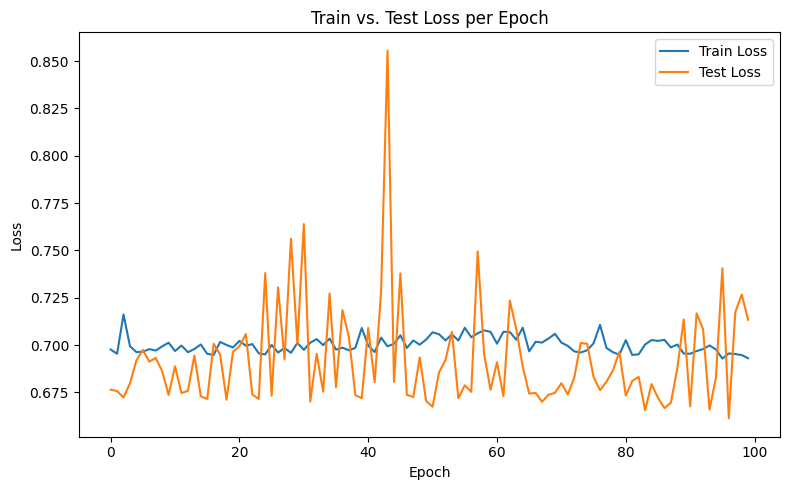

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/overfitting/SPX_val_gru_5_technical.png

----- WINDOW_SIZE: 10, SECURITY_TYPE: technical, MODEL_TYPE: gru -----
Training SPX | Iteration: 1 | Model: lstm | Window_size: 10 | Security type: technical
[Epoch 5/100] Train Loss: 0.6786, Val Loss: 0.7056
[Epoch 10/100] Train Loss: 0.5683, Val Loss: 0.8540
[Epoch 15/100] Train Loss: 0.4136, Val Loss: 1.0270
[Epoch 20/100] Train Loss: 0.2321, Val Loss: 1.3424
[Epoch 25/100] Train Loss: 0.1694, Val Loss: 2.1691
[Epoch 30/100] Train Loss: 0.0778, Val Loss: 2.4864
[Epoch 35/100] Train Loss: 0.1037, Val Loss: 2.6675
[Epoch 40/100] Train Loss: 0.0872, Val Loss: 2.4140
[Epoch 45/100] Train Loss: 0.0982, Val Loss: 2.4311
[Epoch 50/100] Train Loss: 0.0565, Val Loss: 2.9874
[Epoch 55/100] Train Loss: 0.1130, Val Loss: 3.1535
[Epoch 60/100] Train Loss: 0.0884, Val Loss: 2.7432
[Epoch 65/100] Train Loss: 0.0731, Val Loss: 3.9221
[Epoch 70/100] Train Loss: 0.0782, Val Loss: 3

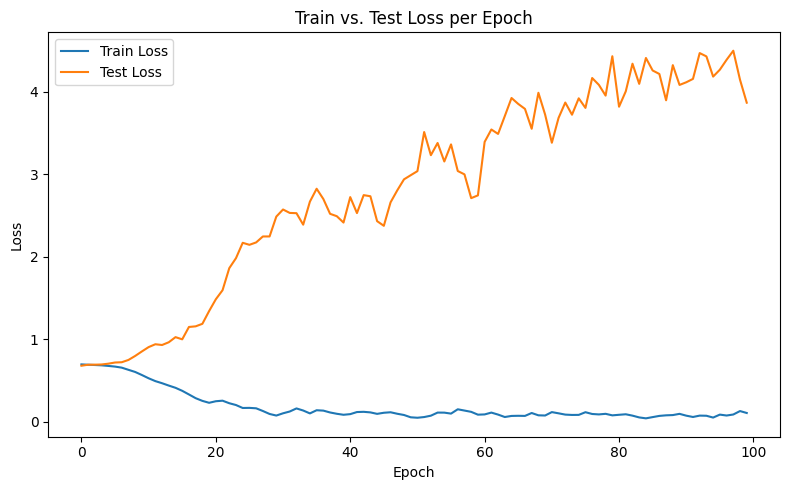

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/overfitting/SPX_val_lstm_10_technical.png
Training SPX | Iteration: 1 | Model: gru | Window_size: 10 | Security type: technical
[Epoch 5/100] Train Loss: 0.7291, Val Loss: 0.6762
[Epoch 10/100] Train Loss: 0.7190, Val Loss: 0.6846
[Epoch 15/100] Train Loss: 0.7043, Val Loss: 0.6836
[Epoch 20/100] Train Loss: 0.7011, Val Loss: 0.6938
[Epoch 25/100] Train Loss: 0.7076, Val Loss: 0.6960
[Epoch 30/100] Train Loss: 0.7141, Val Loss: 0.7171
[Epoch 35/100] Train Loss: 0.7033, Val Loss: 0.7073
[Epoch 40/100] Train Loss: 0.7029, Val Loss: 0.6955
[Epoch 45/100] Train Loss: 0.7149, Val Loss: 0.6930
[Epoch 50/100] Train Loss: 0.6987, Val Loss: 0.7124
[Epoch 55/100] Train Loss: 0.7037, Val Loss: 0.7103
[Epoch 60/100] Train Loss: 0.7020, Val Loss: 0.7203
[Epoch 65/100] Train Loss: 0.6969, Val Loss: 0.7062
[Epoch 70/100] Train Loss: 0.6911, Val Loss: 0.7478
[Epoch 75/100] Train Loss: 0.6942, Val Loss: 0.7404
[Epoch 80/100

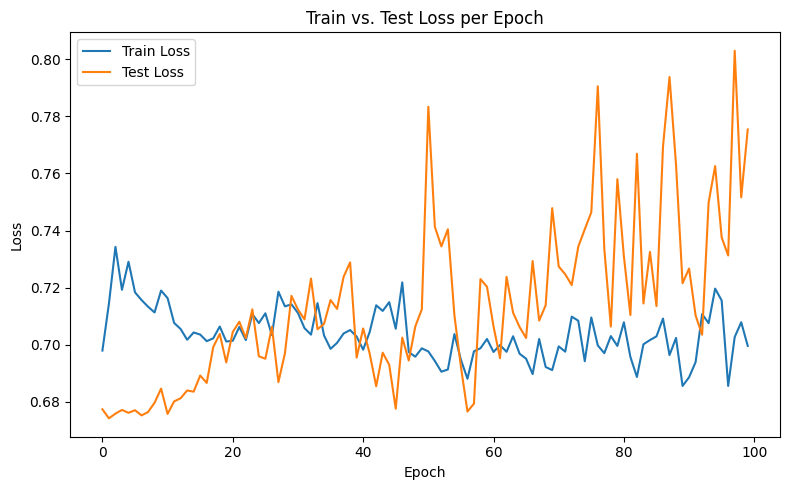

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/overfitting/SPX_val_gru_10_technical.png

----- WINDOW_SIZE: 50, SECURITY_TYPE: technical, MODEL_TYPE: gru -----
Training SPX | Iteration: 1 | Model: lstm | Window_size: 50 | Security type: technical
[Epoch 5/100] Train Loss: 0.4451, Val Loss: 0.8550
[Epoch 10/100] Train Loss: 0.0400, Val Loss: 1.7953
[Epoch 15/100] Train Loss: 0.0115, Val Loss: 2.1259
[Epoch 20/100] Train Loss: 0.0006, Val Loss: 2.3866
[Epoch 25/100] Train Loss: 0.0003, Val Loss: 2.5069
[Epoch 30/100] Train Loss: 0.0002, Val Loss: 2.6091
[Epoch 35/100] Train Loss: 0.0001, Val Loss: 2.7022
[Epoch 40/100] Train Loss: 0.0001, Val Loss: 2.7908
[Epoch 45/100] Train Loss: 0.0000, Val Loss: 2.8776
[Epoch 50/100] Train Loss: 0.0000, Val Loss: 2.9642
[Epoch 55/100] Train Loss: 0.0000, Val Loss: 3.0511
[Epoch 60/100] Train Loss: 0.0000, Val Loss: 3.1385
[Epoch 65/100] Train Loss: 0.0000, Val Loss: 3.2269
[Epoch 70/100] Train Loss: 0.0000, Val Loss: 

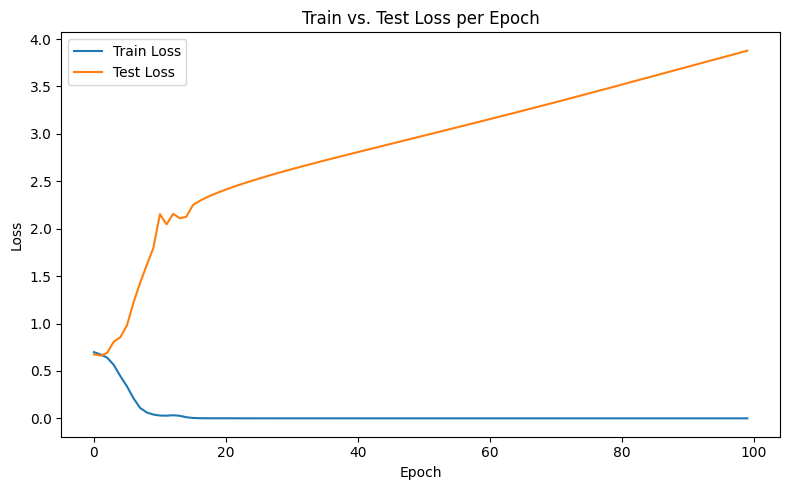

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/overfitting/SPX_val_lstm_50_technical.png
Training SPX | Iteration: 1 | Model: gru | Window_size: 50 | Security type: technical
[Epoch 5/100] Train Loss: 0.7157, Val Loss: 0.6839
[Epoch 10/100] Train Loss: 0.7091, Val Loss: 0.7396
[Epoch 15/100] Train Loss: 0.7042, Val Loss: 0.7198
[Epoch 20/100] Train Loss: 0.7042, Val Loss: 0.6899
[Epoch 25/100] Train Loss: 0.6851, Val Loss: 0.6927
[Epoch 30/100] Train Loss: 0.7044, Val Loss: 0.6798
[Epoch 35/100] Train Loss: 0.6968, Val Loss: 0.6812
[Epoch 40/100] Train Loss: 0.7124, Val Loss: 0.7126
[Epoch 45/100] Train Loss: 0.7204, Val Loss: 0.6794
[Epoch 50/100] Train Loss: 0.7856, Val Loss: 0.7116
[Epoch 55/100] Train Loss: 0.7642, Val Loss: 0.7445
[Epoch 60/100] Train Loss: 0.7222, Val Loss: 0.6939
[Epoch 65/100] Train Loss: 0.7277, Val Loss: 0.6740
[Epoch 70/100] Train Loss: 0.7730, Val Loss: 0.6825
[Epoch 75/100] Train Loss: 0.7705, Val Loss: 0.6925
[Epoch 80/100

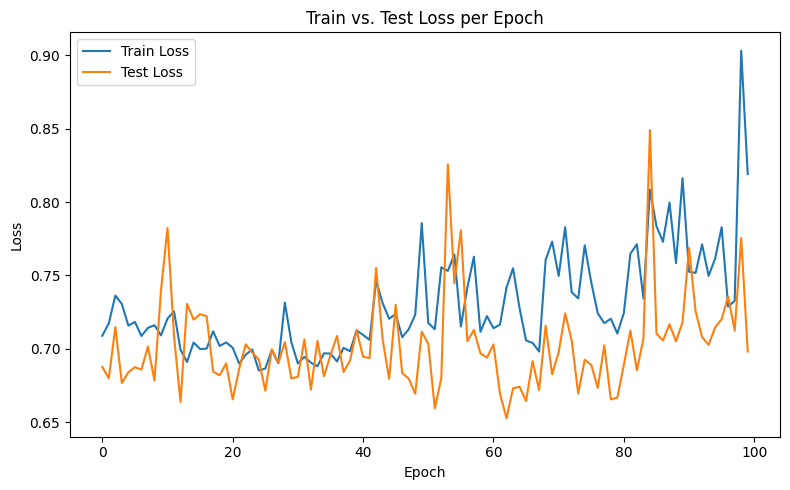

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/overfitting/SPX_val_gru_50_technical.png

----- WINDOW_SIZE: 100, SECURITY_TYPE: technical, MODEL_TYPE: gru -----
Training SPX | Iteration: 1 | Model: lstm | Window_size: 100 | Security type: technical


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [19]:
results_list = []
stock = "SPX"
period = "10y"
possible_train_size = 95
batch_size = 16
num_epochs = 100
window_size = 3
prediction_threshold = 0.5

processing = "clean"
security_types = ["single_name", "options", "technical"]
security_types = ["single_name", "options", "technical"]
learning_rate = 0.01
model_types = ["lstm", "gru"]
model_type = "lstm"
window_sizes = [5, 10, 50, 100]
sample_size = 1

results_list = []
for security_type in security_types:
    for window_size in window_sizes:
        initial_data_dir = os.path.join(project_dir, f"00_data/{processing}") 

        # 1) Load original data (info only)
        filename = f"{security_type}/{stock}/{period}_data.csv"
        original_input_filepath = os.path.join(initial_data_dir, filename)
        original_data = pd.read_csv(original_input_filepath)

        print(f"\n----- WINDOW_SIZE: {window_size}, SECURITY_TYPE: {security_type}, MODEL_TYPE: {model_type} -----")

        # 2) Load the preprocessed data
        pkl_filename = f"{processing}/{security_type}/{stock}/{period}_{window_size}_data.pkl"
        input_filepath = os.path.join(horizontal_data_dir, pkl_filename)
        input_df = pd.read_pickle(input_filepath)

        # 3) Reshape
        X_resampled, y_resampled = reshape_remove_characters(input_df)

        input_size = X_resampled.shape[2]
        train_size = int(X_resampled.shape[0] * possible_train_size / 100)
        test_size = X_resampled.shape[0] - train_size


        for model_type in model_types:
                # 4) Initialize the model
            if model_type == "gru":
                model = GRU3DClassifier(input_size, hidden_size, output_size, num_layers, dropout)
            elif model_type == "lstm":
                model = StockPriceLSTM(input_size, hidden_size, output_size)

            model = model.to(device)

            # 5) Set up optimizer
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            
            for i in range(sample_size):
                print(f"Training {stock} | Iteration: {i+1} | Model: {model_type} "
                      f"| Window_size: {window_size} | Security type: {security_type}")

                result = evaluate_model_plot(
                    model=model,
                    X=X_resampled,
                    y=y_resampled,
                    criterion=criterion,
                    optimizer=optimizer,
                    device=device,
                    train_size=train_size,
                    batch_size=batch_size,
                    num_epochs=num_epochs,
                    lower_threshold=0.5,
                    plots_dir=plots_dir,
                    plot_filename=f"overfitting/{stock}_val_{model_type}_{window_size}_{security_type}.png" # optional custom filename
                )

                # 7) Extract results
                rolling_predictions = result["rolling_predictions"]
                rolling_targets = result["rolling_targets"]
                test_accuracy = result["accuracy_nonzero"]
                loss_decrease_percentage = result["loss_decrease_percentage"]
                nonzero_preds = np.count_nonzero(rolling_predictions)
                final_train_loss = result["final_train_loss"]

                # 9) Create a record (dictionary) for this run
                run_record = {
                    "STOCK": stock,
                    "DATA_TYPE": security_type,
                    "MODEL": model_type.upper(),
                    "WINDOW_SIZE": window_size,
                    "ACCURACY": test_accuracy,
                    "TRAIN_PCT_DECREASE": loss_decrease_percentage,
                    "FINAL_TRAIN_LOSS": final_train_loss
                }

                # 10) Append to the results_list
                results_list.append(run_record)

In [28]:
results_csv_path

NameError: name 'results_csv_path' is not defined

In [29]:
df = pd.DataFrame(results_list)
output_folder = os.path.join(results_dir, f"overfitting") 
os.makedirs(output_folder, exist_ok=True)

results_csv_path = os.path.join(output_folder, f"{stock}_window_sizes.csv")

In [30]:
df.to_csv(results_csv_path, mode='a', header=False, index=False)